In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
# import statsmodels.api as sm
from tqdm import tqdm
# from multiprocessing.dummy import Pool
import dask.dataframe as dd

pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# pd.set_option('display.max_columns', 500)

In [2]:
#In[] 1,227,297,915 size, 7675it * 10000
crsp_df = pd.read_csv("crsp_d.csv",header=0,
    parse_dates = ['date','DCLRDT','RCRDDT'],
    dtype={
        "PERMNO": str,
        "PRC": np.float64,
        "VOL": np.float64,
        "SHROUT": np.float64,
        "DIVAMT": np.float64,
        "SHRCD":str,
        "DISTCD":str,
        "COMNAM": str,
        "TICKER": str,
        'CUSIP': str,
        "BID": np.float64,
        "ASK": np.float64}, chunksize=100000)
#Data Preprocessing
#In[]
d = {}
one = False
def insert(i,x):
    if str(x)[-1].isdigit() == False:
        return
    x = float(x)
    if i not in d:
        d[i] = [x]
    else:
        d[i].append(x)
    return
cache = []
cache_ddate = set()
for c in tqdm(crsp_df):
    c = c[(c.SHRCD.isin(('10','11'))) ]
    c = c.groupby(by=['CUSIP','date']).agg({
          'DCLRDT': 'last',
          'RCRDDT': 'last',
          'DISTCD': 'last',
          'DIVAMT': 'sum',
          'RET':'last',
          'RETX':'last',
          'PRC': 'last'}).reset_index()
    if not one:
         cusip = c.head(1).reset_index().iloc[0].CUSIP
         one = True
    count = 0
    # c['dt'] = 0
    lastDivDate = None
    for row in c.itertuples():
        if row.CUSIP != cusip:
            cusip = row.CUSIP
            count = 0
            lastDivDate = None
            for row2 in cache:
                if row2[0] in cache_ddate:
                    count = 0
                    insert(count, row2[1])
                    cache_ddate.remove(row2[0])
                    count += 1
                    lastDivDate = True
                elif lastDivDate is not None:
                    insert(count, row2[1])
                    count += 1
            cache = list()
            cache_ddate = set()
        else:
            cache.append((row.date, row.RET))
            if pd.isna(row.RCRDDT) == False:
                cache_ddate.add(row.RCRDDT)
for row2 in cache:
    if row2[0] in cache_ddate:
        count = 0
        insert(count, row2[1])
        cache_ddate.remove(row2[0])
        count += 1
        lastDivDate = True
    elif lastDivDate is not None:
        insert(count, row2[1])
        count += 1        

819it [56:53,  4.17s/it]


In [3]:
#In[] 1,227,297,915 size, 7675it * 10000
crsp_df = pd.read_csv("crsp_d_rev2.csv",header=0,
    parse_dates = ['date','DCLRDT','RCRDDT'],
    dtype={
        "PERMNO": str,
        "PRC": np.float64,
        "VOL": np.float64,
        "SHROUT": np.float64,
        "DIVAMT": np.float64,
        "SHRCD":str,
        "DISTCD":str,
        "COMNAM": str,
        "TICKER": str,
        'CUSIP': str,
        "BID": np.float64,
        "ASK": np.float64}, chunksize=100000)
#Data Preprocessing
#In[]
def insert(i,x):
    if str(x)[-1].isdigit() == False:
        return
    x = float(x)
    if i not in d:
        d[i] = [x]
    else:
        d[i].append(x)
    return
one = False
cache = []
cache_ddate = set()
for c in tqdm(crsp_df):
    c = c[(c.SHRCD.isin(('10','11'))) ]
    c = c.groupby(by=['CUSIP','date']).agg({
          'DCLRDT': 'last',
          'RCRDDT': 'last',
          'DISTCD': 'last',
          'DIVAMT': 'sum',
          'RET':'last',
          'RETX':'last',
          'PRC': 'last'}).reset_index()
    if not one:
         cusip = c.head(1).reset_index().iloc[0].CUSIP
         one = True
    count = 0
    # c['dt'] = 0
    lastDivDate = None
    for row in c.itertuples():
        if row.CUSIP != cusip:
            cusip = row.CUSIP
            count = 0
            lastDivDate = None
            for row2 in cache:
                if row2[0] in cache_ddate:
                    count = 0
                    # insert(count, row.RET)
                    cache_ddate.remove(row2[0])
                    count += 1
                    lastDivDate = True
                elif lastDivDate is not None:
                    insert(count * -1, row2[1])
                    count += 1
            cache = list()
            cache_ddate = set()
        else:
            cache.append((row.date, row.RET))
            if pd.isna(row.RCRDDT) == False:
                cache_ddate.add(row.RCRDDT)
for row2 in cache:
    if row2[0] in cache_ddate:
        count = 0
        # insert(count, row.RET)
        cache_ddate.remove(row2[0])
        count += 1
        lastDivDate = True
    elif lastDivDate is not None:
        insert(count, row2[1])
        count += 1        

723it [3:19:48, 20.20s/it]/Users/ptakchun/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (10,14) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
819it [3:55:10, 17.23s/it]


In [4]:
x = range(-30, 61, 1)
dlist = [ 100*sum(d[key])/len(d[key]) for key in x ]
print(dlist)

[0.029159486015980774, 0.04898353554975436, 0.06364911869872851, 0.06617261956127075, 0.048407344097651475, 0.021148834465575528, 0.05743985492774018, 0.07568023141680275, 0.07671361711219958, 0.0673477341045608, 0.06019313391721306, 0.0678593602623702, 0.07850590473441224, 0.07067540089861615, 0.050076567847543205, 0.06104978197613787, 0.078824600651617, 0.08172792393040125, 0.08359662168338489, 0.06900793526586858, 0.08247310165816345, 0.06940928188967196, 0.07422491679508707, 0.05884271074475685, 0.002444088940118001, 0.028284521056978217, 0.052163791229528245, 0.033636471900061374, 0.01874883258142275, -0.007311957569118899, 0.047069476963421626, -0.007418714586901846, 0.018989006744479908, 0.03353935665909639, 0.05234728388645485, 0.02852584299120993, 0.0026638265568547917, 0.05881873429129063, 0.07406778515993553, 0.06948136171921836, 0.08248546410860395, 0.06919862821489547, 0.08367626096115324, 0.08150064376076617, 0.07886364100055297, 0.06087574918760281, 0.05000143201477519, 

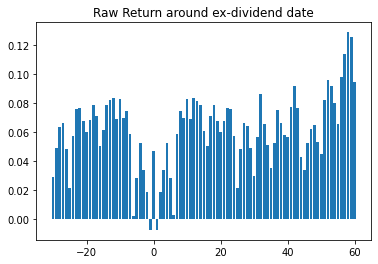

In [5]:
plt.bar(x,dlist)
plt.title('Raw Return around ex-dividend date')
plt.show()

In [6]:
sum(d[0])

234.04403099999098

In [7]:
import pickle
filename = 'RCRDDT_Figure2.pkl'
with open(filename,'wb') as f:
     pickle.dump(dlist, f)

In [8]:
with open(filename,'rb') as f:
     a = pickle.load(f)

a == dlist

True